# 200-D Multivariate Normal

Let's go for broke here.

## Setup

First, let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
# system functions that are always useful to have
import time, sys, os
import pickle

# basic numeric setup
import numpy as np
from numpy import linalg
from scipy import stats

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt

# seed the random number generator
rstate = np.random.default_rng(520)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 30})

In [3]:
import dynesty

Here we will quickly demonstrate that slice sampling is able to cope with very high-dimensional problems without the use of gradients. Our target will in this case be a 250-D uncorrelated multivariate normal distribution with an identical prior.

In [4]:
ndim = 200  # number of dimensions
C = np.identity(ndim)  # set covariance to identity matrix
Cinv = linalg.inv(C)  # precision matrix
lnorm = -0.5 * (np.log(2 * np.pi) * ndim + np.log(linalg.det(C)))  # ln(normalization)

# 250-D iid standard normal log-likelihood
def loglikelihood(x):
    """Multivariate normal log-likelihood."""
    return -0.5 * np.dot(x, np.dot(Cinv, x)) + lnorm


# prior transform (iid standard normal prior)
def prior_transform(u):
    """Transforms our unit cube samples `u` to a standard normal prior."""
    return stats.norm.ppf(u)

# ln(evidence)
lnz_truth = lnorm - 0.5 * ndim * np.log(2)
print(lnz_truth)

-253.10242469692906


We will use Slice Sampling (`'rslice'`) to sample in high dimensions.

In [ ]:
# random slice sampling ('rslice')
sampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim, nlive=500,
                                bound='none', sample='rslice', 
                                slices=40, rstate=rstate)
sampler.run_nested(dlogz=0.01)
res = sampler.results

Now let's see how our sampling went.

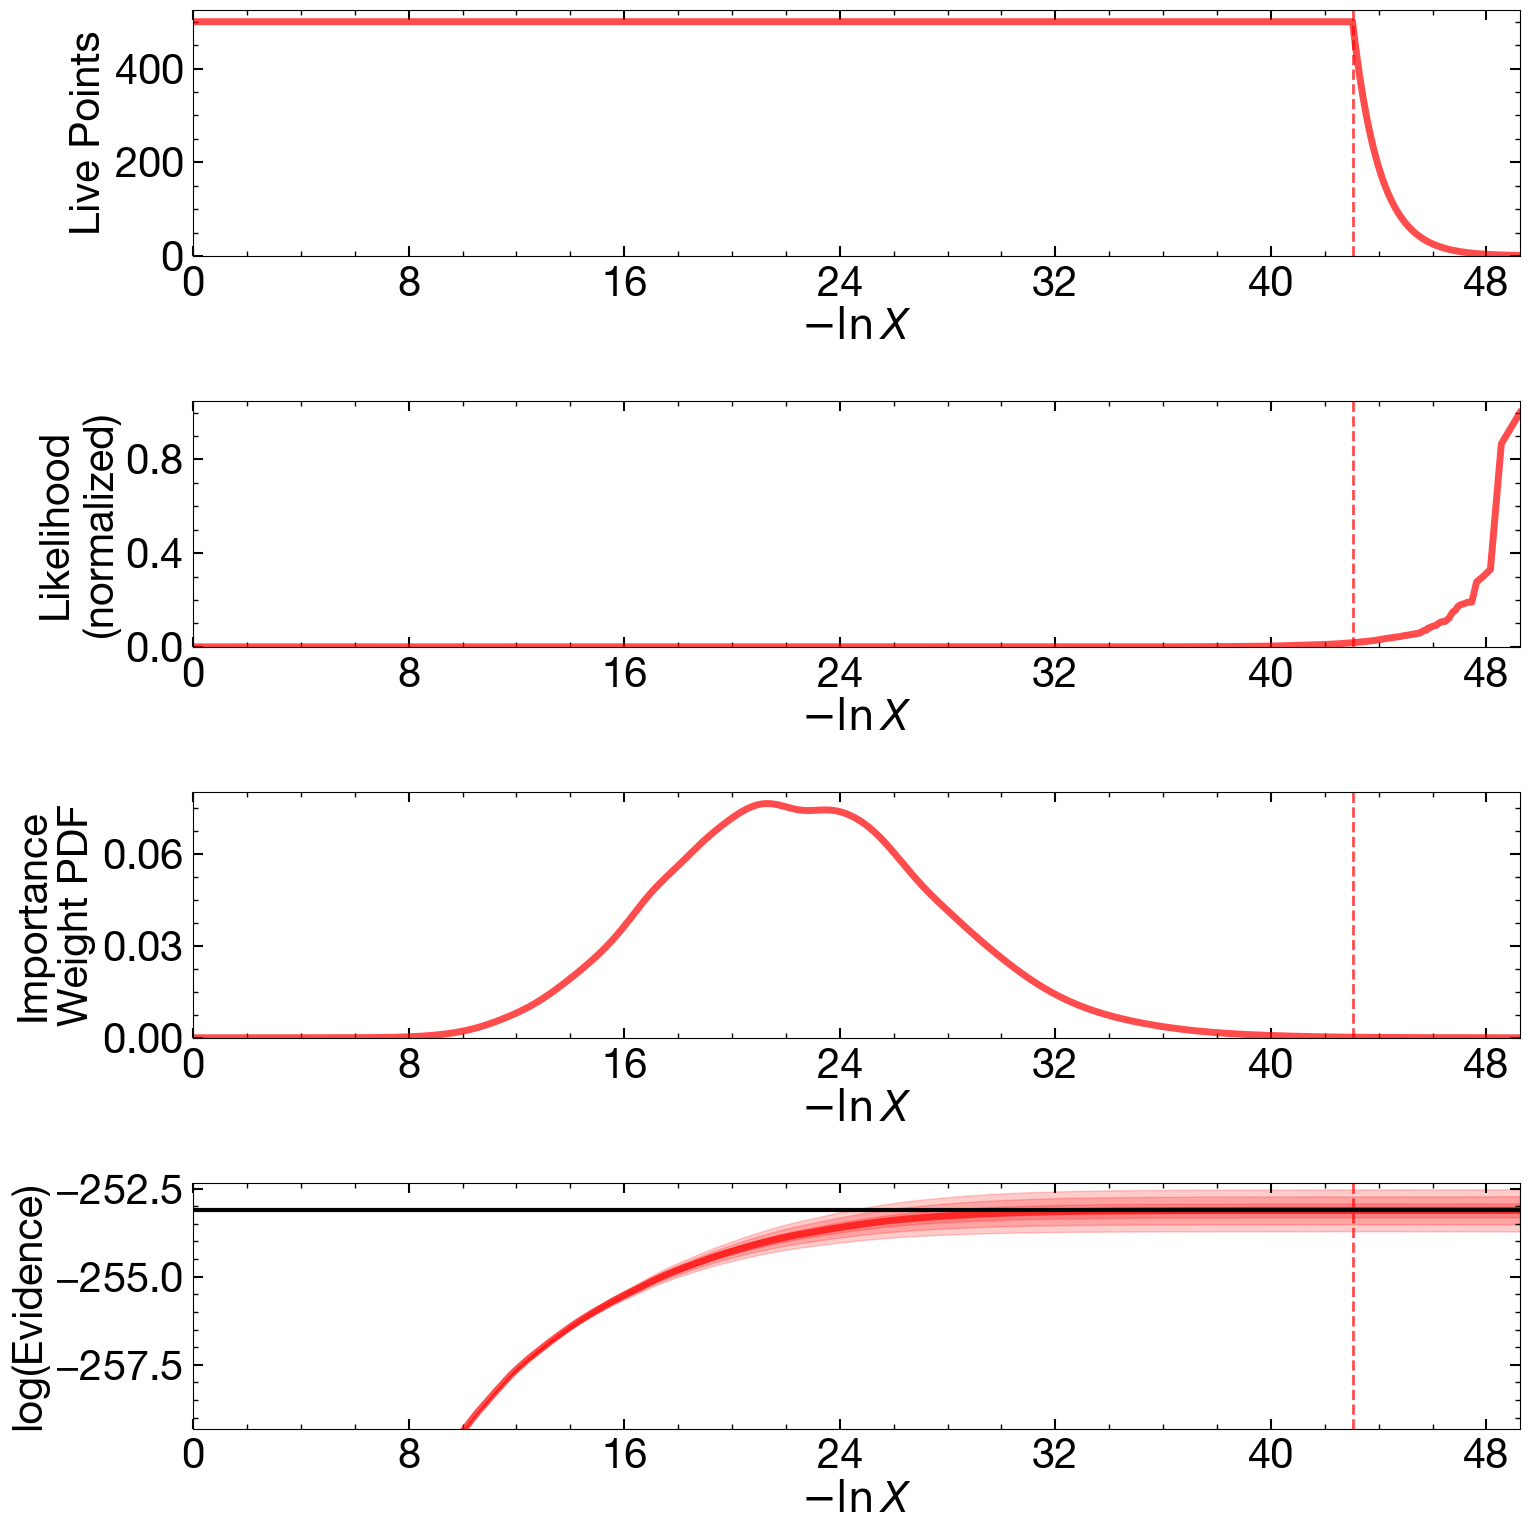

In [6]:
from dynesty import plotting as dyplot

# evidence check
fig, axes = dyplot.runplot(res, color='red', lnz_truth=lnz_truth, truth_color='black', logplot=True)
fig.tight_layout()

1.3859292911256331


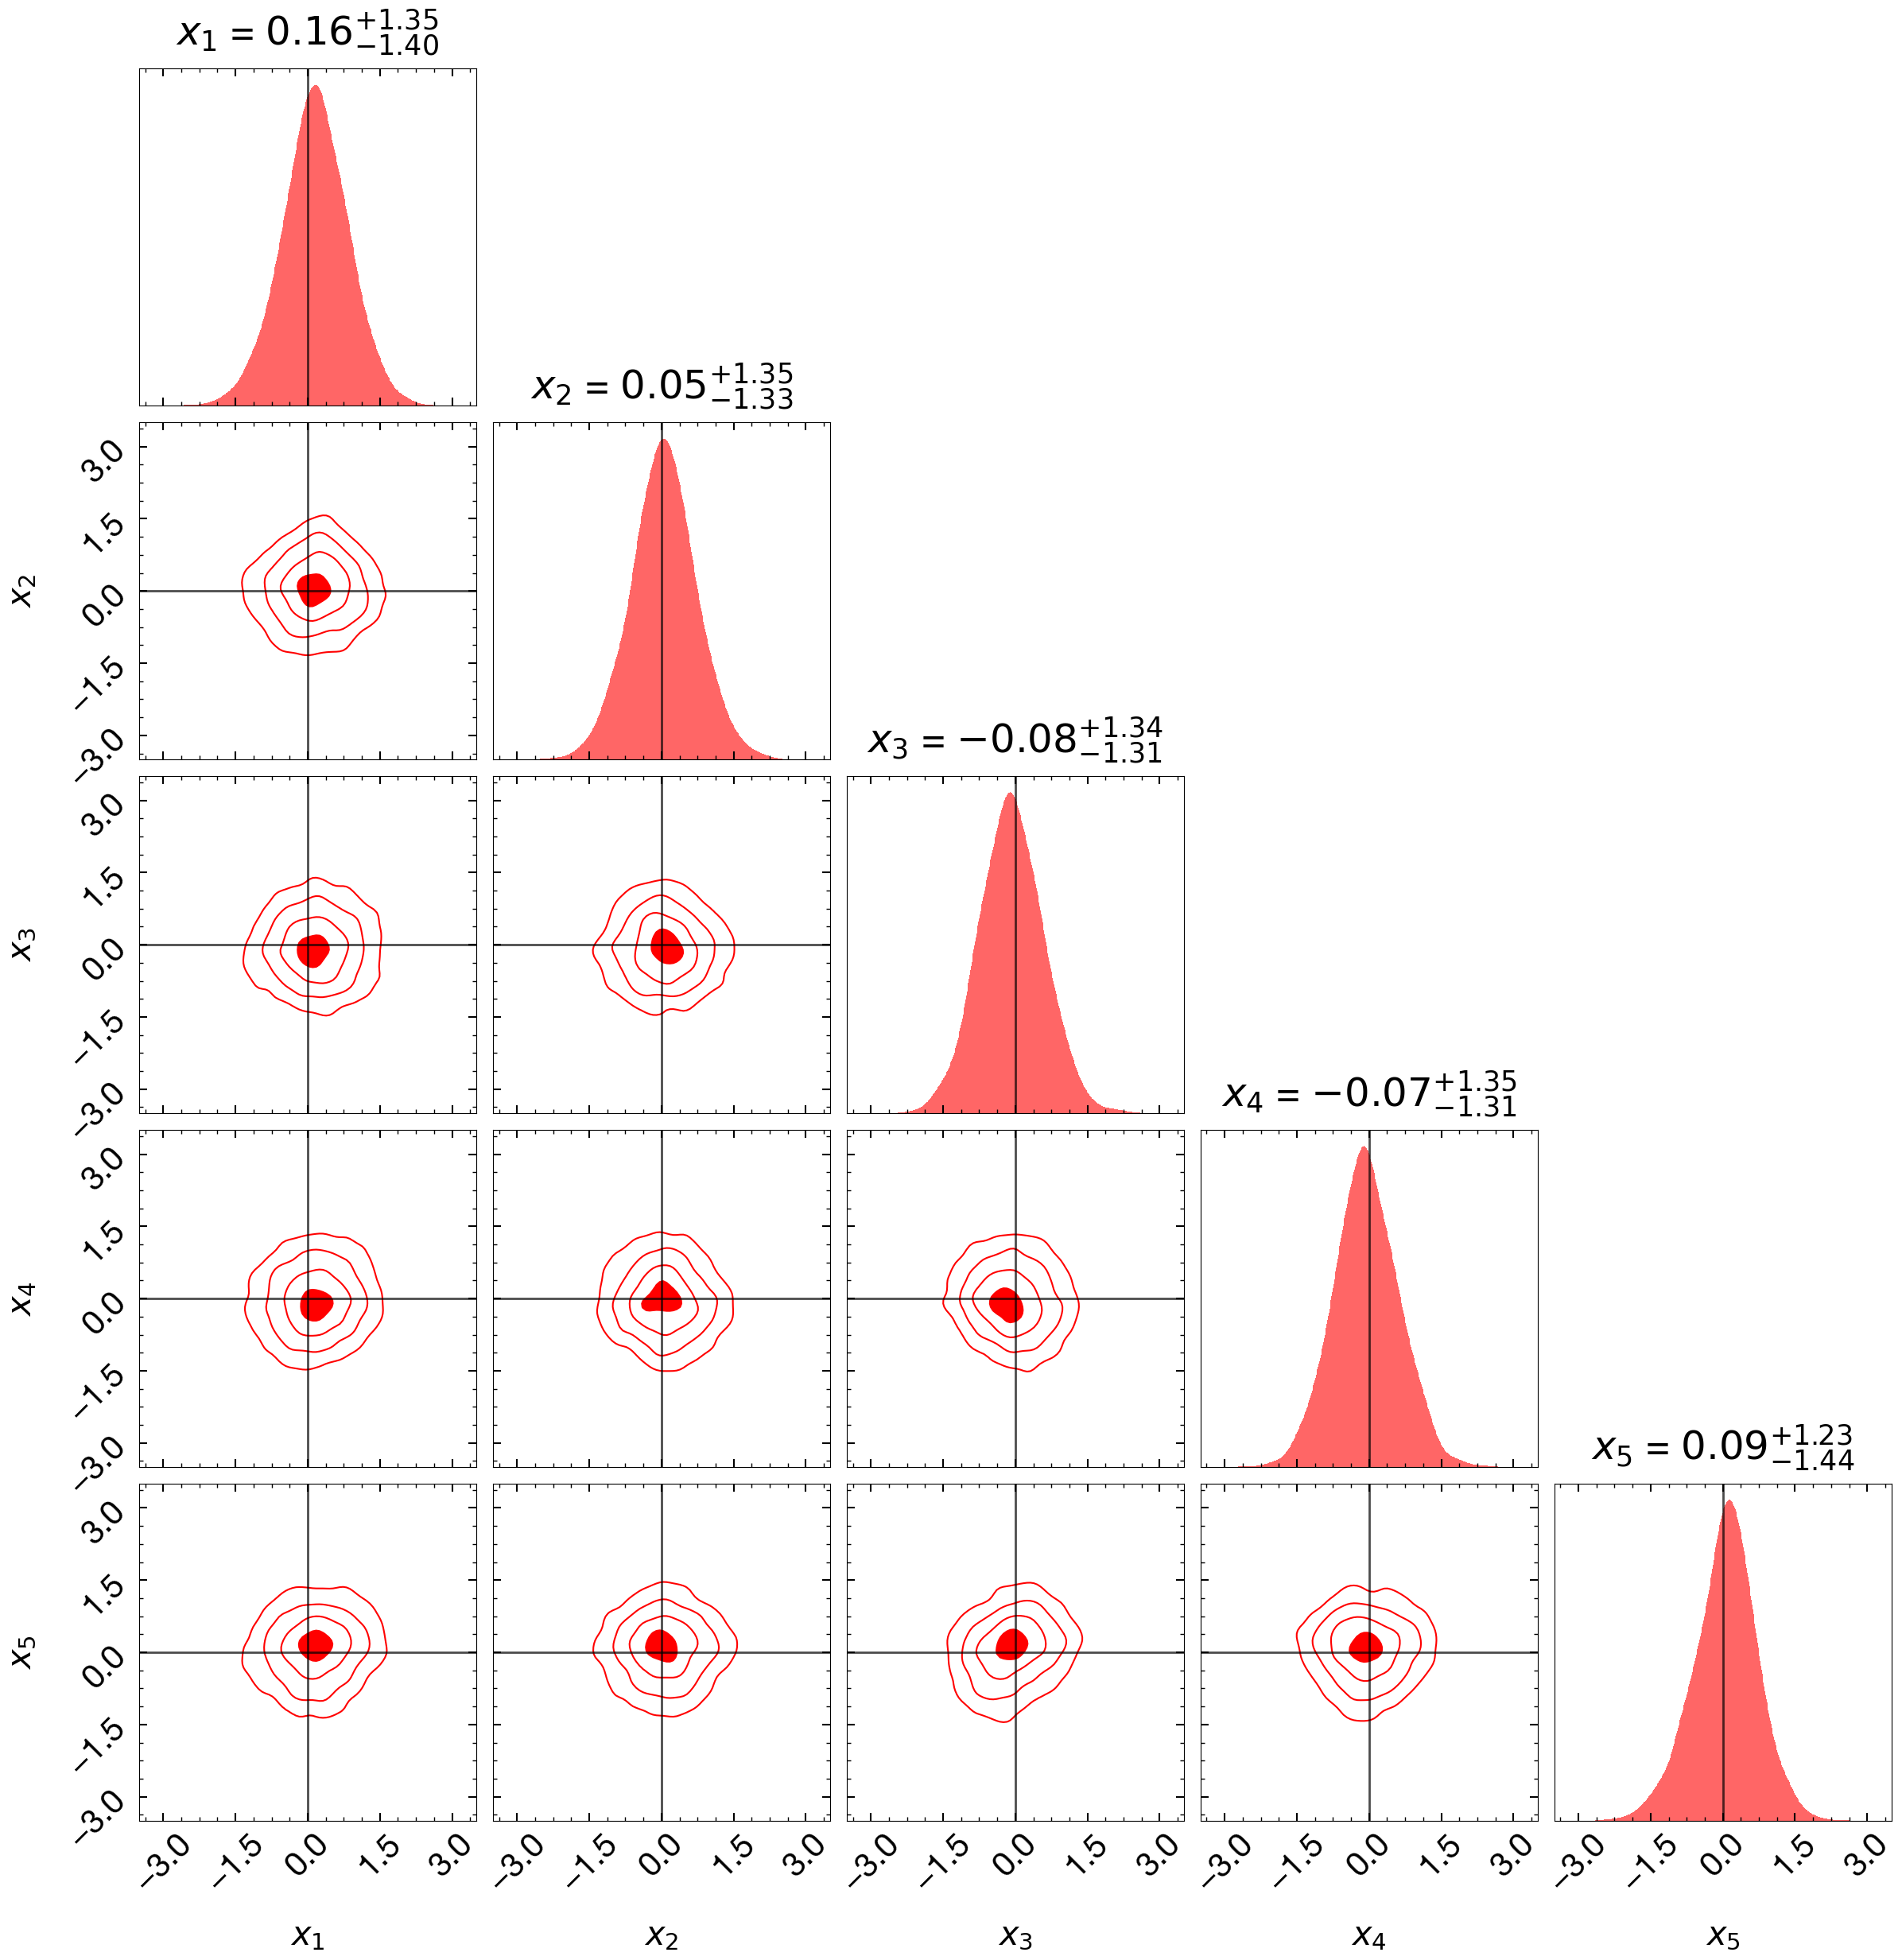

In [7]:
# posterior check
from dynesty.results import Results
dims = [-1, -2, -3, -4, -5]
fig, ax = plt.subplots(5, 5, figsize=(25, 25))
samps, samps_t = res.samples, res.samples[:,dims]
dres = res.asdict()
dres['samples'] = samps_t
res = Results(dres)
fg, ax = dyplot.cornerplot(res, color='red', truths=np.zeros(ndim), truth_color='black',
                           span=[(-3.5, 3.5) for i in range(len(dims))],
                           show_titles=True, title_kwargs={'y': 1.05},
                           quantiles=None, fig=(fig, ax))
dres = res.asdict()
dres['samples'] = samps
res = Results(dres)
print(1.96 / np.sqrt(2))

That looks good! Obviously we can't plot the full 200x200 plot, but 5x5 subplots should do.

Now we can finally check how well our mean and covariances agree.

In [8]:
# let's confirm we actually got the entire distribution
from dynesty import utils

weights = np.exp(res.logwt - res.logz[-1])
mu, cov = utils.mean_and_cov(samps, weights)

/tmp/ipykernel_340629/1428865120.py:2: DeprecationWarning: Please import `gaussian_kde` from the `scipy.stats` namespace; the `scipy.stats.kde` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.kde import gaussian_kde


Means (0.): 0.00748762108582689 +/- 0.09881774286467093
Variance (0.5): 0.48748637685818613 +/- 0.03582633077145126
Covariance (0.): 0.00032154520730099073 +/- 0.04082595542080783


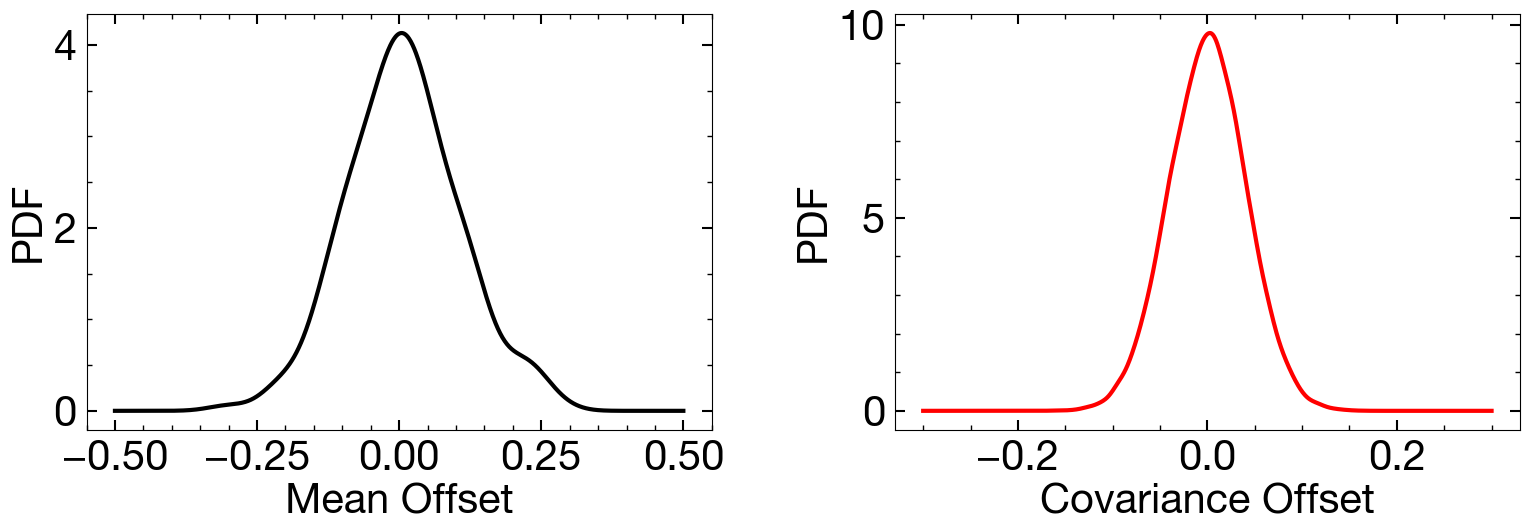

In [9]:
# plot residuals
from scipy.stats.kde import gaussian_kde
mu_kde = gaussian_kde(mu)
xgrid = np.linspace(-0.5, 0.5, 1000)
mu_pdf = mu_kde.pdf(xgrid)
cov_kde = gaussian_kde((cov - C).flatten())
xgrid2 = np.linspace(-0.3, 0.3, 1000)
cov_pdf = cov_kde.pdf(xgrid2)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(xgrid, mu_pdf, lw=3, color='black')
plt.xlabel('Mean Offset')
plt.ylabel('PDF')
plt.subplot(1, 2, 2)
plt.plot(xgrid2, cov_pdf, lw=3, color='red')
plt.xlabel('Covariance Offset')
plt.ylabel('PDF')

# print values
print('Means (0.):', np.mean(mu), '+/-', np.std(mu))
print('Variance (0.5):', np.mean(np.diag(cov)), '+/-', np.std(np.diag(cov)))
cov_up = np.triu(cov, k=1).flatten()
cov_low = np.tril(cov,k=-1).flatten()
cov_offdiag = np.append(cov_up[abs(cov_up) != 0.], cov_low[cov_low != 0.])
print('Covariance (0.):', np.mean(cov_offdiag), '+/-', np.std(cov_offdiag))
plt.tight_layout()

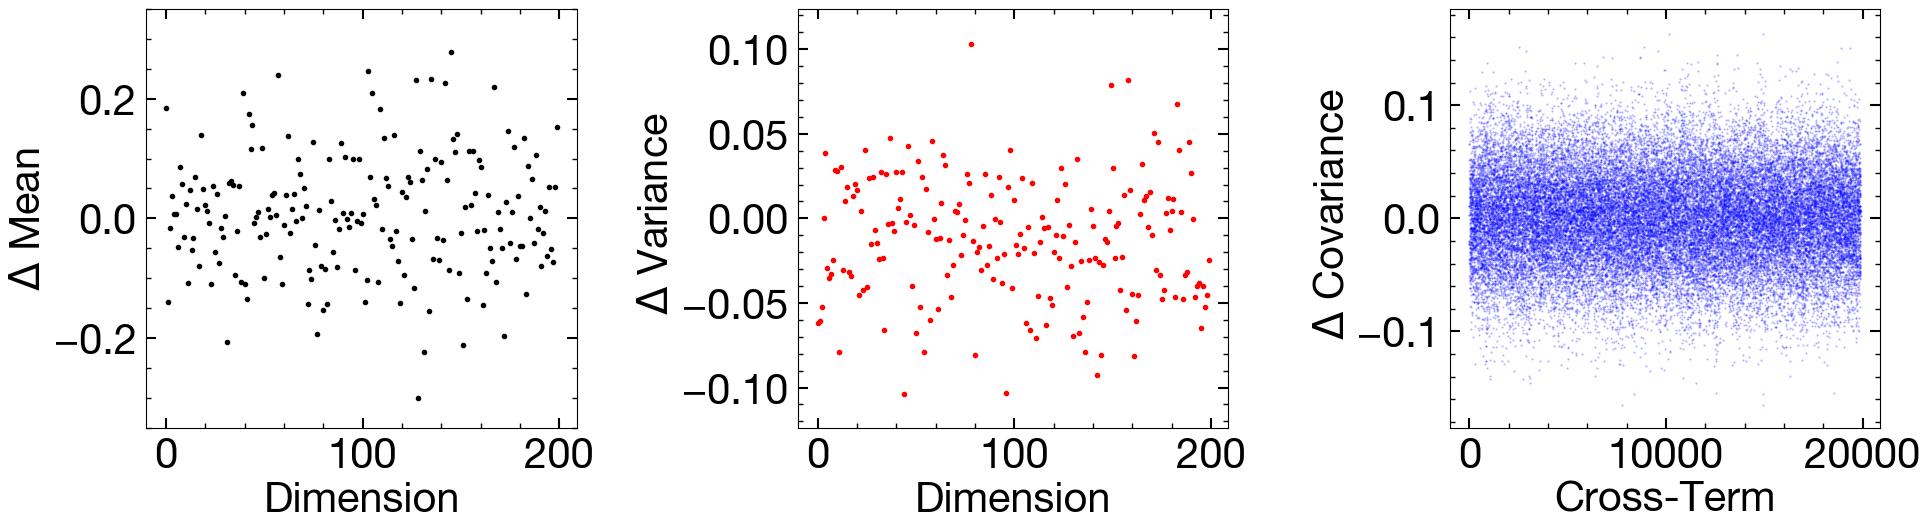

In [10]:
# plot individual values
plt.figure(figsize=(20,6))
plt.subplot(1, 3, 1)
plt.plot(mu, 'k.')
plt.ylabel(r'$\Delta$ Mean')
plt.xlabel('Dimension')
plt.ylim([-np.max(np.abs(mu)) - 0.05,
          np.max(np.abs(mu)) + 0.05])
plt.tight_layout()

plt.subplot(1, 3, 2)
dcov = np.diag(cov) - 0.5
plt.plot(dcov, 'r.')
plt.ylabel(r' $\Delta$ Variance')
plt.xlabel('Dimension')
plt.ylim([-np.max(np.abs(dcov)) - 0.02,
          np.max(np.abs(dcov)) + 0.02])
plt.tight_layout()

plt.subplot(1, 3, 3)
dcovlow = cov_low[cov_low != 0.]
dcovup = cov_up[cov_up != 0.]
dcovoff = np.append(dcovlow, dcovup)
plt.plot(dcovlow, 'b.', ms=1, alpha=0.3)
plt.plot(dcovup, 'b.', ms=1, alpha=0.3)
plt.ylabel(r' $\Delta$ Covariance')
plt.xlabel('Cross-Term')
plt.ylim([-np.max(np.abs(dcovoff)) - 0.02,
          np.max(np.abs(dcovoff)) + 0.02])
plt.tight_layout()